# NKX6-2
[autosomal recessive spastic ataxia-8 with hypomyelinating leukodystrophy (SPAX8)](https://omim.org/entry/617560) is caused by homozygous or compound heterozygous mutation in the NKX6-2 gene.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2025-01-16
Using gpsea version 0.9.6.dev0


### NKX6-2
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for NKX6-2.

In [2]:
from gpsea.preprocessing import configure_default_protein_metadata_service

gene_symbol = 'NKX6-2'
mane_tx_id = 'NM_177400.3'
mane_protein_id = 'NP_796374.2' # homeobox protein Nkx-6.2
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.24") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Individuals Processed: 100%|██████████| 33/33 [00:00<00:00, 233.15 individuals/s]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
32,Spasticity
29,Nystagmus
24,Motor delay
24,Global developmental delay
20,Hyperreflexia
19,Hypotonia
18,CNS hypomyelination
13,Loss of ambulation
9,Ataxia
7,Abnormal pyramidal sign


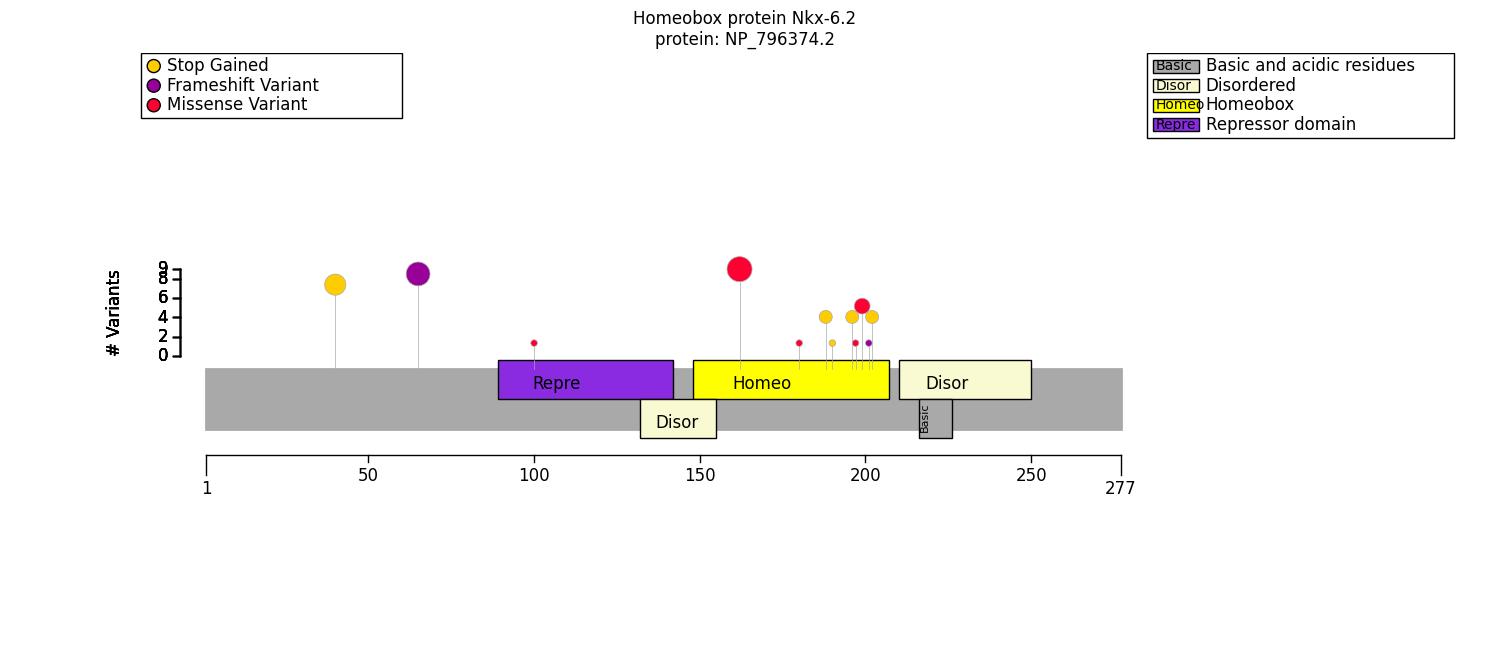

In [5]:
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

nkx6_2_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein(
    protein_metadata=protein_meta,
    cohort=cohort,
    ax=ax,
)
nkx6_2_fig.tight_layout()

# Genotype-Phenotype Correlation (GPC) Analysis
15 of the 33 variants are missense, with the rest being loss of function categories. We will also test the region including the Repressor region and N-terminal to that, and the most commonly observed variants.

In [6]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)

pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [7]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate import variant_effect
from gpsea.analysis.clf import biallelic_classifier
from gpsea.view import MtcStatsViewer

missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_clf = biallelic_classifier(
    a_predicate=missense,
    b_predicate=~missense,
    a_label="missense",
    b_label="other",
    partitions=((0,), (2,1))
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(missense_result)

Reason,Count
Skip terms if all counts are identical to counts for a child term,2
"Skipping ""general"" level terms",38
Skipping terms that are rare on the cohort level (in less than 40% of the cohort members),95


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=missense_result)

Allele group,missense/missense,other/other OR missense/other,Corrected p values,p values
CNS hypomyelination [HP:0003429],3/5 (60%),15/15 (100%),0.691176,0.052632
Seizure [HP:0001250],3/8 (38%),0/9 (0%),0.691176,0.082353
Loss of ambulation [HP:0002505],3/6 (50%),10/11 (91%),0.691176,0.098739
Thin corpus callosum [HP:0033725],1/5 (20%),5/9 (56%),0.998419,0.300699
Hypometric saccades [HP:0000571],4/7 (57%),3/11 (27%),0.998419,0.332202
Nystagmus [HP:0000639],9/10 (90%),20/20 (100%),0.998419,0.333333
Hypotonia [HP:0001252],7/11 (64%),12/14 (86%),0.998419,0.350000
Global developmental delay [HP:0001263],9/10 (90%),15/22 (68%),0.998419,0.380350
Tube feeding [HP:0033454],1/5 (20%),4/11 (36%),1.000000,1.000000
Scoliosis [HP:0002650],1/5 (20%),4/14 (29%),1.000000,1.000000


In [9]:
from gpsea.analysis.predicate import variant_key

l163v = variant_key("10_132785372_132785372_G_C") # c.487C>G; p.Leu163Val

l163v_predicate = biallelic_classifier(
        a_predicate=l163v,
        b_predicate=~l163v,
        a_label="L163V",
        b_label="other"
    , partitions={(0,), (1,2)})
l163v_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=l163v_predicate,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=l163v_result)

Allele group,L163V/L163V,L163V/other OR other/other,Corrected p values,p values
CNS hypomyelination [HP:0003429],3/5 (60%),15/15 (100%),0.855245,0.052632
Global developmental delay [HP:0001263],8/8 (100%),16/24 (67%),0.855245,0.081452
Loss of ambulation [HP:0002505],2/4 (50%),11/13 (85%),1.000000,0.218908
Thin corpus callosum [HP:0033725],1/5 (20%),5/9 (56%),1.000000,0.300699
Hypometric saccades [HP:0000571],3/5 (60%),4/13 (31%),1.000000,0.325980
Seizure [HP:0001250],2/6 (33%),1/11 (9%),1.000000,0.514706
Ataxia [HP:0001251],1/3 (33%),8/12 (67%),1.000000,0.525275
Scoliosis [HP:0002650],0/3 (0%),5/16 (31%),1.000000,0.530444
Tube feeding [HP:0033454],1/3 (33%),4/13 (31%),1.000000,1.000000
Morphological central nervous system abnormality [HP:0002011],3/3 (100%),15/15 (100%),1.000000,1.000000


In [10]:
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_region

n_term = protein_region(Region(0,160), tx_id=mane_tx_id)
nterm_predicate = biallelic_classifier(
    a_predicate=n_term,
    b_predicate=~n_term,
    a_label="N term",
    b_label="other",
    partitions={(0,1), (2,)})
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=nterm_predicate,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group,N term/N term OR N term/other,other/other,Corrected p values,p values
Global developmental delay [HP:0001263],8/15 (53%),16/17 (94%),0.279792,0.013323
Scoliosis [HP:0002650],0/7 (0%),5/12 (42%),1.000000,0.106037
Hypometric saccades [HP:0000571],3/11 (27%),4/7 (57%),1.000000,0.332202
Hypotonia [HP:0001252],5/8 (62%),14/17 (82%),1.000000,0.344190
Nystagmus [HP:0000639],12/13 (92%),17/17 (100%),1.000000,0.433333
CNS hypomyelination [HP:0003429],8/8 (100%),10/12 (83%),1.000000,0.494737
Loss of ambulation [HP:0002505],9/11 (82%),4/6 (67%),1.000000,0.584034
Tube feeding [HP:0033454],1/6 (17%),4/10 (40%),1.000000,0.587912
Seizure [HP:0001250],1/8 (12%),2/9 (22%),1.000000,1.000000
Motor delay [HP:0001270],10/10 (100%),14/14 (100%),1.000000,1.000000


In [11]:
from gpsea.analysis.clf import sex_classifier

mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, mf_result)

Sex,FEMALE,MALE,Corrected p values,p values
Tube feeding [HP:0033454],0/7 (0%),5/9 (56%),0.706731,0.033654
Hypotonia [HP:0001252],8/13 (62%),11/12 (92%),1.000000,0.160248
Scoliosis [HP:0002650],4/10 (40%),1/9 (11%),1.000000,0.303406
Nystagmus [HP:0000639],13/14 (93%),16/16 (100%),1.000000,0.466667
Loss of ambulation [HP:0002505],6/9 (67%),7/8 (88%),1.000000,0.576471
Thin corpus callosum [HP:0033725],4/7 (57%),2/7 (29%),1.000000,0.592075
Ataxia [HP:0001251],5/7 (71%),4/8 (50%),1.000000,0.608392
Global developmental delay [HP:0001263],10/14 (71%),14/18 (78%),1.000000,0.703493
Motor delay [HP:0001270],11/11 (100%),13/13 (100%),1.000000,1.000000
Hyperreflexia [HP:0001347],11/11 (100%),9/9 (100%),1.000000,1.000000


# Summary

In [12]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary


FET_results = (
   GPAnalysisResultSummary.from_multi(
        result=missense_result,
    
    ),
    GPAnalysisResultSummary.from_multi(
        result=l163v_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=nterm_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=mf_result
    )
)


nkx6_2_caption = "No statistically significant results identified."
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=FET_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=nkx6_2_caption)

In [13]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
missense/missense,other/other OR missense/other,21,0
Genotype (A),Genotype (B),Tests performed,Significant tests
L163V/L163V,L163V/other OR other/other,21,0
Genotype (A),Genotype (B),Tests performed,Significant tests
N term/N term OR N term/other,other/other,21,0
Genotype (A),Genotype (B),Tests performed,Significant tests
FEMALE,MALE,21,0


In [14]:
summarizer.process_latex(report=report, protein_fig=nkx6_2_fig)

Figure saved to ../../supplement/img/NKX6-2_protein_diagram-draft.pdf
Output to ../../supplement/tex/NKX6-2_summary_draft.tex
